In [1]:
# Fill in your name using the format below and student ID number
your_name = "van Cauter, Zeno"
student_id = "0935906"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Zeno, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [8]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

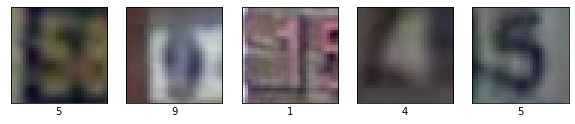

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_20 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                2570      
Total params: 3,411,722
Trainable params: 3,411,722
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.594173  0.272032  0.644417      0.401649
max  2.044070  0.817733  1.739467      0.806886
Answer is 471 characters long


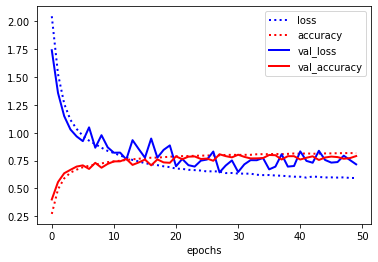

In [16]:
def build_model_1_1():
    model_1_1 = models.Sequential()
    model_1_1.add(layers.Flatten(input_shape=(32, 32, 3)))
    model_1_1.add(layers.Dense(1024, activation='sigmoid'))
    model_1_1.add(layers.Dense(256, activation='sigmoid'))
    model_1_1.add(layers.Dense(10, activation='softmax'))
    model_1_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_1_1

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
                   train=False, epochs=50, batch_size=64)
    
answer_q_1_1 = """
               First, a 32x32=1024 Dense layer to capture this color dimensionality.
               Next we take a 256-Dense layer (1/4th) because halving the size everytime gives
               a too long model which also heavily overfits (results not shown here). After that we immedietly
               go to a dense layer of 10 for our classifications.
               We achieve a ~80% accuracy & val_accuracy so our model does not under nor overfit.
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [17]:
# Frequency of classes in the data
frequency = dict(zip(*np.unique(np.argmax(y_val, axis=1), return_counts=True)))
for k,v in frequency.items():
    frequency[k] = [v, np.round(v*100/len(np.argmax(y_val, axis=1)),decimals=2)]
frequency

{0: [3034, 19.1],
 1: [2357, 14.84],
 2: [1821, 11.46],
 3: [1597, 10.05],
 4: [1483, 9.33],
 5: [1233, 7.76],
 6: [1218, 7.67],
 7: [1073, 6.75],
 8: [1000, 6.29],
 9: [1071, 6.74]}

In [18]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
Success!
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_23 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_24 (Dense)             (None, 10)                2570      
Total params: 1,314,570
Trainable params: 1,314,570
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.347952  0.282780  0.569856      0.445836
max  2.006388  0.890564  1.614097      0.838862
Answer is 720 characters long


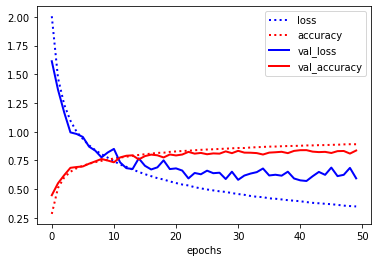

In [19]:
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    model_1_2 = models.Sequential()
    model_1_2.add(layers.Flatten(input_shape=(32, 32, 1)))
    model_1_2.add(layers.Dense(1024, activation='sigmoid'))
    model_1_2.add(layers.Dense(256, activation='sigmoid'))
    model_1_2.add(layers.Dense(10, activation='softmax'))
    model_1_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_1_2

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=64)
answer_q_1_2 = """
               For this question we have only preprocessed the data using gray-scaling. There is a small
               class imbalance in the data. I have left this data unchanged because
               i feel that this is not due to a sampling bias but due to Benford's Law.
               Link: https://en.wikipedia.org/wiki/Benford%27s_law
               
               It means that the imbalance isnt due to poor sampling, but its just how the numbers are actually distributed.
               This led to a small increase in accuracy on the testdata (~2%) which is a nice improvement.
               We also see that the validation loss does not increase and hence the model also does not overfit
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                2570      
Total params: 1,314,570
Trainable params: 1,314,570
Non-trainable params: 0
___________

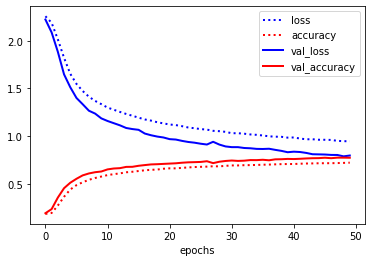

In [20]:
def build_model_1_3():
    model_1_3 = models.Sequential()
    model_1_3.add(layers.Flatten(input_shape=(32, 32, 1)))
    model_1_3.add(layers.Dense(1024, activation='sigmoid'))
    model_1_3.add(layers.Dropout(0.5))
    model_1_3.add(layers.Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
    model_1_3.add(layers.Dropout(0.5))
    model_1_3.add(layers.Dense(10, activation='softmax'))
    model_1_3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_1_3
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=64)

answer_q_1_3 = """
               Using only Dropout(using 0.5, other values perform worse) gives a val_acc above acc and 
               val_loss below loss meaning it greatly improves performance of the model.
               Using a lower LR (0.0003) makes the model converge quicker towards its "average" accuracy
               BatchNormalization makes the loss-function much more 'squiggly' without a clear improvement
               Regularization only works good when using L2 with a parameter >=0.0001 and 
               only in the 256-dense layer. L1, L1_L2 or a too big param make the model useless (0.190 acc).
               We end up using Dropout(0.5), L2-regularization with a small parameter and a smaller LR.
               This gives us again a val_loss below the training loss and val_accuracy above training accuracy.
               We have lost a bit of accuracy compared to our previous models but it now generalizes much better (although the accuracy is still pretty bad, ~78%).
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)   

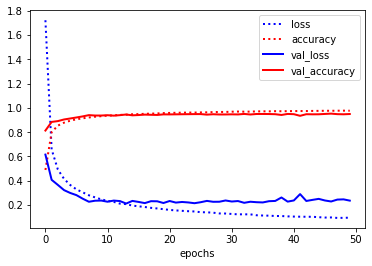

In [21]:
def build_model_2_1():
    model_2_1 = models.Sequential()
    model_2_1.add(layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(32, 32, 1)))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.Dropout(0.2))
    model_2_1.add(layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.Dropout(0.3))
    model_2_1.add(layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.Dropout(0.4))
    model_2_1.add(layers.Conv2D(256, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Conv2D(256, (3, 3), activation='sigmoid', padding='same'))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.Dropout(0.5))
    model_2_1.add(layers.Flatten())
    model_2_1.add(layers.Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Dropout(0.5))
    model_2_1.add(layers.Dense(10, activation='softmax'))
    model_2_1.compile(optimizer=optimizers.RMSprop(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_2_1

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=64)

answer_q_2_1 = """
               Ive decided to use the a default model that is similar to the one from the lab, 
               but augmented with an additional deep layer and the 0.5 dropout.
               We also use an L2-regularizer in the big dense layer (which is increased) because
               we use a have a deeper filter map.
               Finally, we only use sigmoid activations (because for now we have the computational 
               power due to GPU usage) and an adapted learning rate.
               
               This model should allow for the recognition of smaller patterns.
               After 50 epochs, the model tends to overfit the training data because 
               the loss keeps decreasing but the validation loss does not.
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_46 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)   

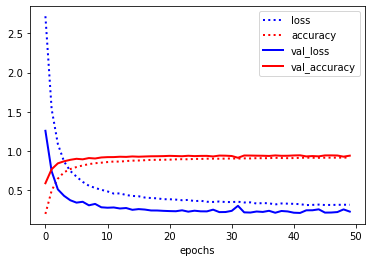

In [22]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=22,
    fill_mode='nearest')

it_train = train_datagen.flow(rgb2gray(X_train), y_train)
    
augmented_split = it_train, rgb2gray(X_val), y_val
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=False, epochs=50, batch_size=None, generator=True, steps_per_epoch=1000)
answer_q_2_2 = """
               Naively i used many different methods such as horizontal flips, vertical flips, 
               full 360 degree rotations, etc. i got extremely poor results. It dawned upon me pretty
               quickly that using such augmentations is a stupid idea because we are working with numbers
               and numbers using mirroring or rotations doesnt work very well from this context perspective.
               Therefore i decided to only use "modest" augmentation methods e.g. small shifting and 
               rotations up to 22 degrees and leave it at that.
               This results in a better performance (no more overfitting) and better generalization for
               future test data as the performance on the test data is once again higher than on the training data
               We lose a bit of accuracy (.7%) but greatly gain on other territories.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

0.9397620696166678


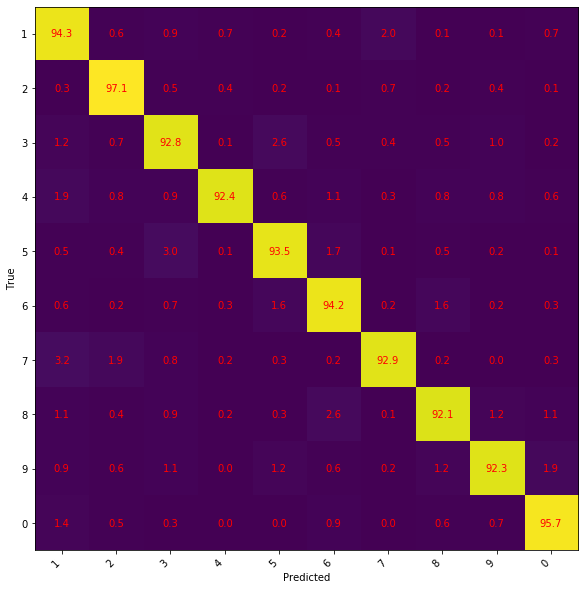

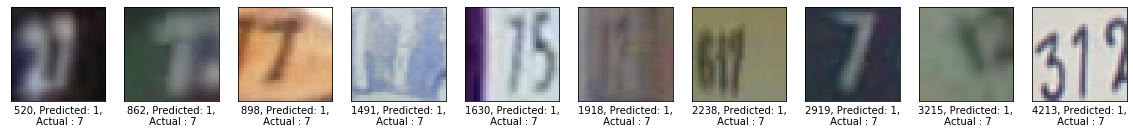

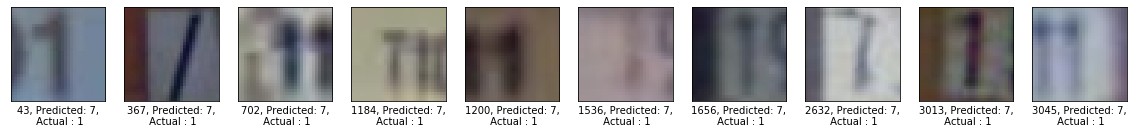

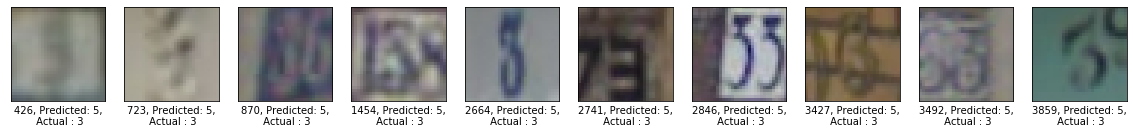

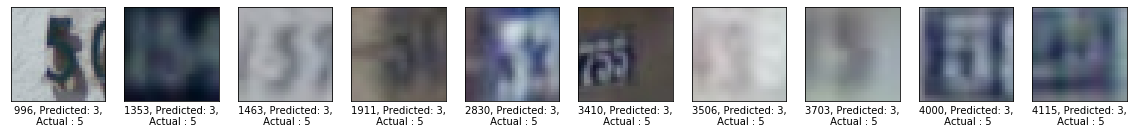

Answer is 829 characters long


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Import model, make predictions and make list of misclassifications
model_2_2 = load_model_from_file(base_dir, "model_2_2", extension='.h5')
y_pred = model_2_2.predict(preprocessed_split[1])
cifar_classes = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5,
                 5: 6, 6: 7, 7: 8, 8: 9, 9: 0}

# Compute accuracy from final model, different from highest accuracy during training
test_accuracy_3_1 = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
print(test_accuracy_3_1)

def plot_confusion_matrix():
    cm = np.around(np.around(confusion_matrix(np.argmax(y_val, axis=1),np.argmax(y_pred, axis=1), normalize='true'), decimals=3)*100, decimals=2)
    #cm = confusion_matrix(np.argmax(y_val, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(cifar_classes.values()), rotation=45, ha="right")
    ax.set_yticklabels(list(cifar_classes.values()))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="r")

plot_confusion_matrix()

def plot_misclassifications():
    helper_misclasplot(6,0)
    helper_misclasplot(0,6)
    helper_misclasplot(2,4)
    helper_misclasplot(4,2)
    #helper_misclasplot(7,5)

    
def helper_misclasplot(true_label, pred_label):
    misclassified_samples_6_0 = np.nonzero((np.argmax(y_val, axis=1) == true_label) &
                                        (np.argmax(y_pred, axis=1) == pred_label))[0]
    fig, axes = plt.subplots(1, 10,  figsize=(20, 5))
    for nr, i in enumerate(misclassified_samples_6_0[:10]):
        axes[nr].imshow(X_val[i])
        axes[nr].set_xlabel("%s, Predicted: %s,\n Actual : %s" % (i,
                                                                  cifar_classes[np.argmax(y_pred[i])],
                                                                  cifar_classes[np.argmax(y_val[i])]))
        axes[nr].set_xticks(()), axes[nr].set_yticks(())

    plt.show();

plot_misclassifications()

answer_q_3_1 = """
               I've plotted a CM normalized by row. Every row shows how much % was classified to each other.
               First observation, the highest misclassification is 3.2% and occurs when 7 gets classified as 1.
               This misclassification is "symmetric" because 1 also often (2%) gets misclassified as 7.
               Other noteworthy misclassifications are the pairs 3-5, 5-3, 8-6.
               
               From the big plot of our most common classifications, we find that 
               there is lots of noise in the data. Some digits have been misclassified when making the dataset,
               some pictures contain multiple digits and have not been seperated correctly and some pictures
               are probably not even identifiable by a human due to the unreadableness.
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

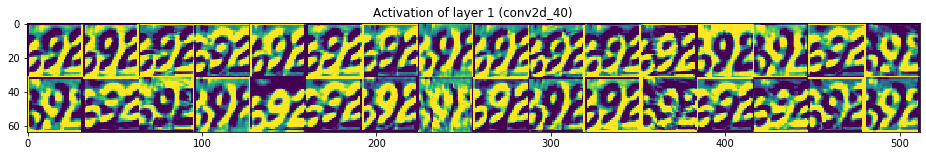

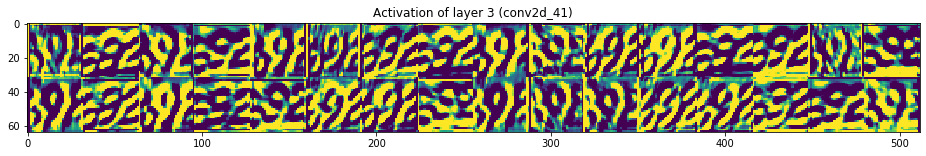

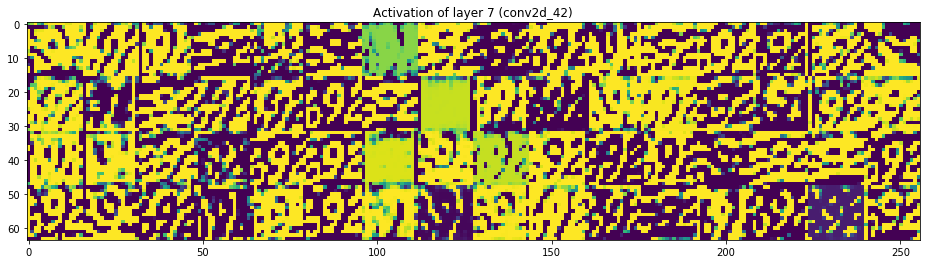

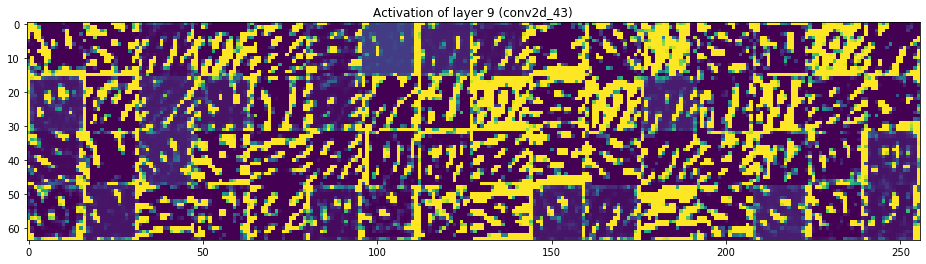

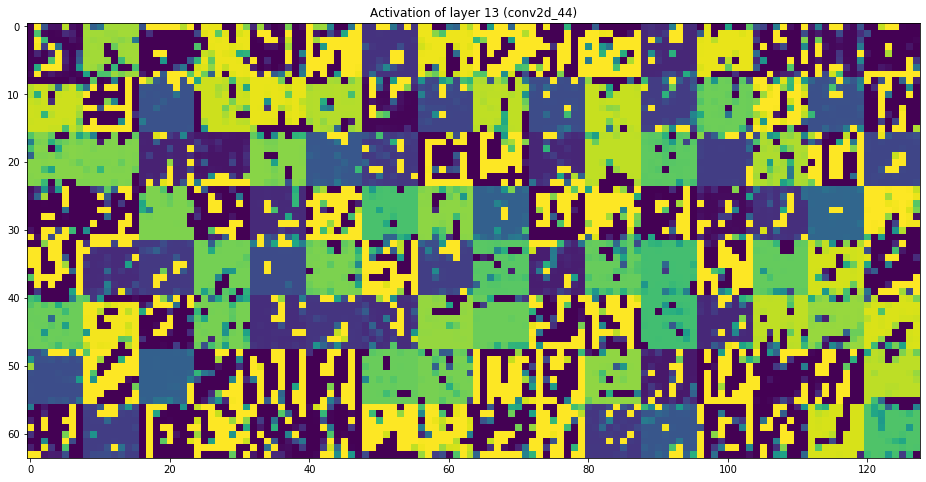

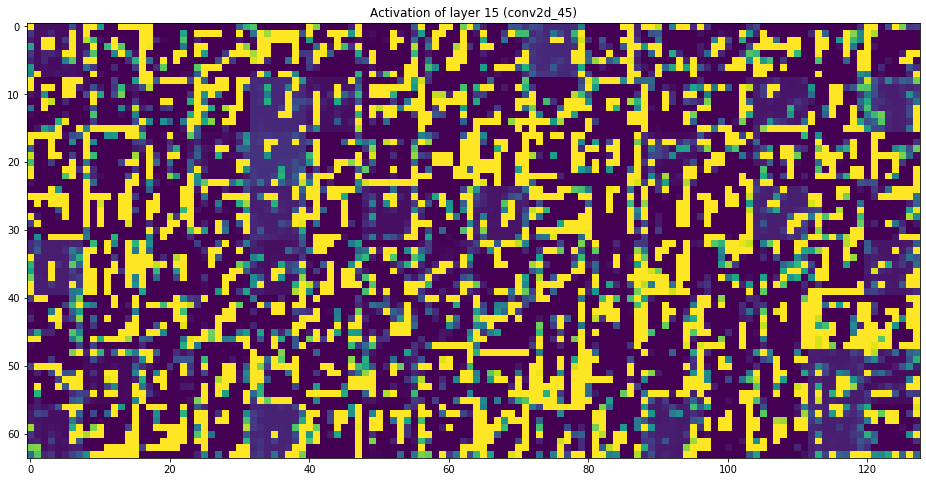

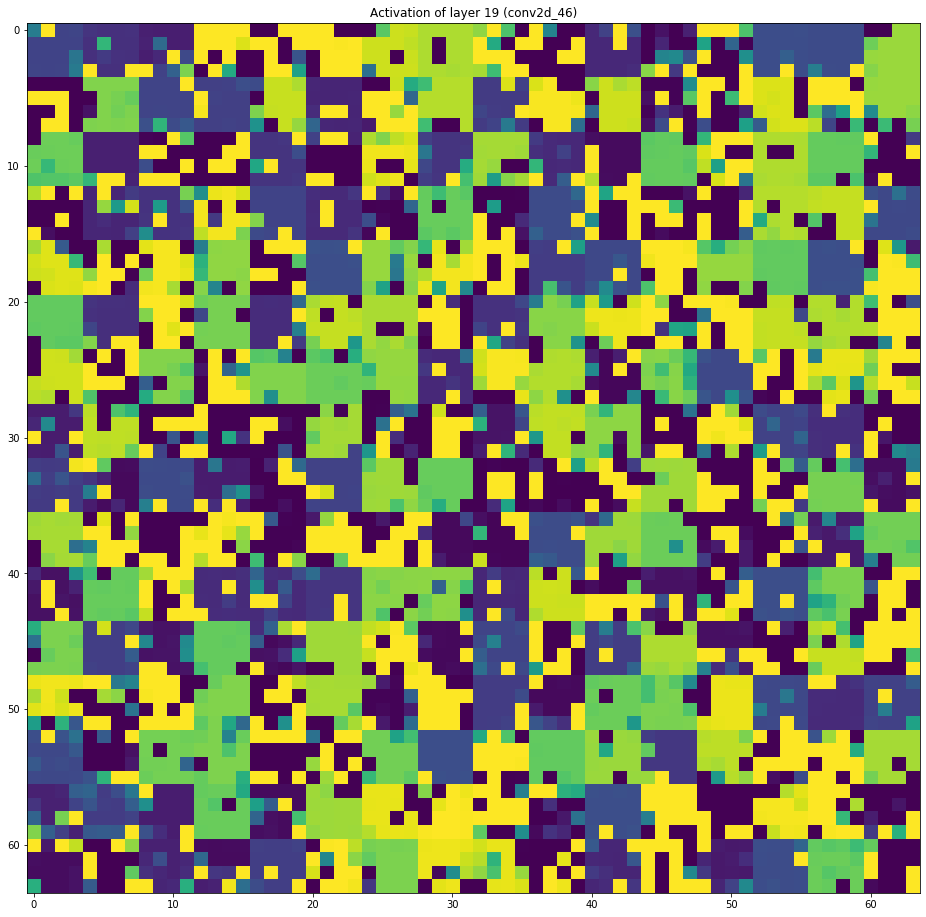

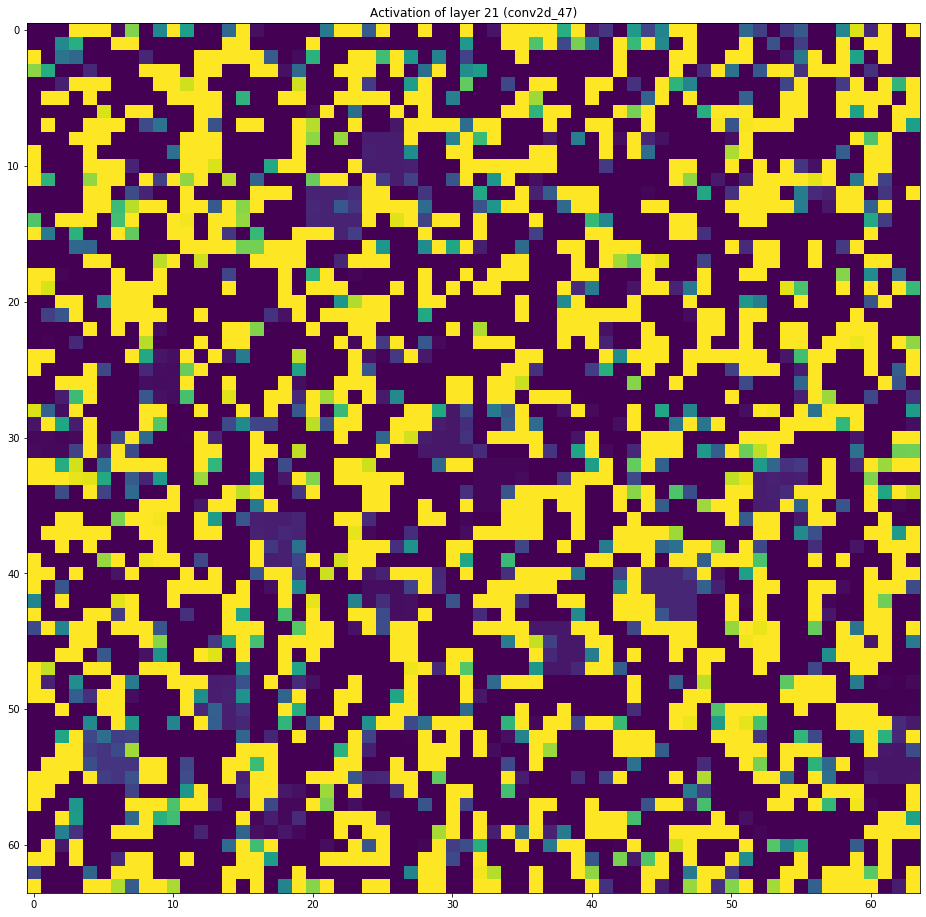

Answer is 522 characters long


In [24]:
def plot_activations():
    model_2_2 = load_model_from_file(base_dir, "model_2_2", extension='.h5')

    img_tensor = preprocessed_split[1][0]
    img_tensor = np.expand_dims(img_tensor, axis=0) 

    # Extracts the outputs of the top 8 layers:
    layer_outputs = [layer.output for layer in model_2_2.layers]
    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)

    # This will return a list of 5 Numpy arrays:
    # one array per layer activation
    activations = activation_model.predict(img_tensor)
    images_per_row = 16

    layer_names = []
    i = 0
    for layer in model_2_2.layers:
        layer_names.append(layer.name)
        #print(layer.name, i)
        i += 1
        
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 256
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
layer_index = 0
plot_activations()    
layer_index = 2
plot_activations()
layer_index = 6
plot_activations()    
layer_index = 8
plot_activations()
layer_index = 12
plot_activations()
layer_index = 14
plot_activations()
layer_index = 18
plot_activations()
layer_index = 20
plot_activations()

answer_q_3_2 = """
               In layer 1,3 and 7 we still see that many of the filters show a 9 clearly, albeit in decreasing amount.
               In layer 9 is still represented in a few filters but in the maps 13 and 17 there is no more
               real patterns for "nine-ness" and there are only very abstract representations. 
               This is also made difficult by the small resolution that we are working with which becomes
               more and more abstract the further we head into deeper layers.
               """
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Tensor("dense_20/Softmax:0", shape=(None, 10), dtype=float32)


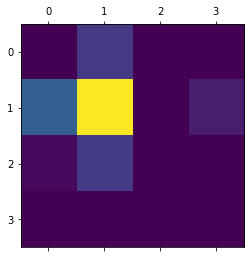

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


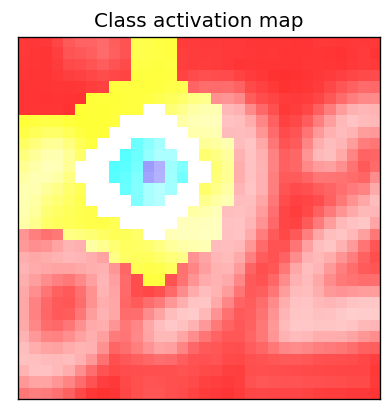

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2
K.clear_session()

#For some reason i would get the error:
#"RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead."
#This is supposed to solve that
tf.compat.v1.disable_eager_execution()

def plot_activation_map():
    model_2_2 = load_model_from_file(base_dir, "model_2_2", extension='.h5')
    print(y_val[0])
    x = preprocessed_split[1][0]
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    number = model_2_2.output[:, 9]
    print(model_2_2.output)
    
    
    last_conv_layer = model_2_2.get_layer('conv2d_47')
    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `block5_conv3`
    grads = K.gradients(number, last_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model_2_2.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation

    heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
    return heatmap
 
# I am calling the plot in plot_3_3 so to prevent double plots ive moved it    
#plot_activation_map()

def plot_3_3():
    img = preprocessed_split[1][0]
    # We resize the heatmap to have the same size as the original image
    heatmap = plot_activation_map()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img
    
    # Save the image to disk
    #cv2.imwrite('../images/elephant_cam.jpg', superimposed_img)
    #img = cv2.imread('../images/elephant_cam.jpg')
    #RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.rcParams['figure.dpi'] = 120
    plt.imshow(superimposed_img)
    #plt.imshow(RGB_im)
    plt.title('Class activation map')
    plt.xticks([])
    plt.yticks([])
    plt.show()
        
plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

In [26]:
# Check what layers are in the model for later use. VGG has 5 blocks.
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.969871  0.438531  1.154142      0.492667
max  1.627741  0.670701  1.488138      0.615031
Answer is 1080 characters long


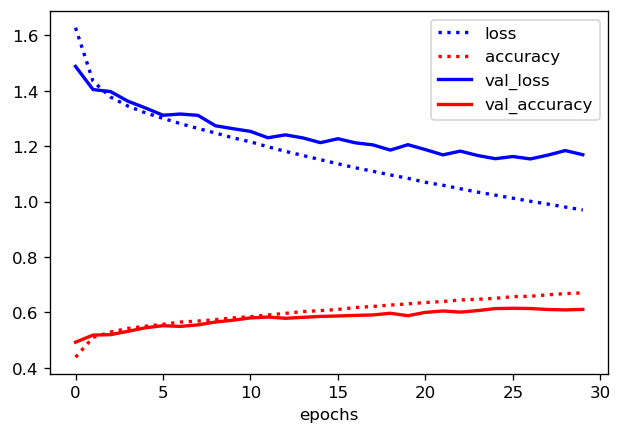

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
def build_model_4_1():
    conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
    model_4_1 = models.Sequential()
    model_4_1.add(conv_base)
    model_4_1.add(layers.Flatten())
    model_4_1.add(layers.Dense(512, activation='sigmoid'))
    model_4_1.add(layers.Dense(10, activation='sigmoid'))
    
    all_layers = ['block1_conv1', 'block1_conv2', 
                 'block2_conv1', 'block2_conv2', 
                 'block3_conv1', 'block3_conv2', 'block3_conv3',
                 'block4_conv1', 'block4_conv2', 'block4_conv3', 
                 'block5_conv1', 'block5_conv2', 'block5_conv3']
    trainable_layers = []
    for layer in conv_base.layers:
        set_trainable = False
        if layer.name in trainable_layers:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
            
    model_4_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_4_1
    
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=False, epochs=30, batch_size=64)

answer_q_4_1 = """
               Fully trainable base: Unlearns everything it learned, 0.1910 acc
               Block 2,3,4 and 5 trainable: Unlearns everything it learned, 0.1910 acc
               Block 3,4 and 5 trainable: Unlearns everything it learned, 0.1910 acc
               BLock 4 and 5 trainable: Unlearns everything it learned, 0.1910 acc
               Block5 trainable: Starts at 70% acc, accuracy then decreases (to 40%) and loss goes up (by a factor of 2).Fully non-trainable: ~60% acc after 20 epochs.
               Only the newly added dense layers trainable: getting upto ~61% accuracy.
               Increasing the number of epochs also makes the model overfit to get 0.190 acc.
               
               All this low 0.190 accuracy means that the model only predicts 0 and is useless.
               The model performs quite poorly. While we couldve increased the number of epochs the performance
               will suddenly crash cause it starts to heavily overfit (and i want something to use in 4.2) and not keep increasing like the plot suggests.
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [32]:
import pickle
import gzip
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

def store_embedding(X, name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_4_1 = load_model_from_file(base_dir, "model_4_1", extension='.h5')
    # Double pop to remove dense layers
    model_4_1.pop()
    model_4_1.pop()
    model_4_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    store_embedding(model_4_1.predict(X_train), "X_train")
    store_embedding(model_4_1.predict(X_test), "X_test")
    store_embedding(model_4_1.predict(X_val), "X_val")    


def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    clfs = [LogisticRegression(C=10, random_state=1), 
            svm.SVC(kernel='rbf',random_state=1, max_iter=100), 
            RandomForestClassifier(random_state=1)] 
    #Take only 1 classifier
    classifier = clfs[0]
    
    #Only use 1 scaler because the embeddings yield huge numbers
    #scaler=MaxAbsScaler()
    scaler=StandardScaler()
    #scaler=MinMaxScaler()
    #scaler=Normalizer()
    return Pipeline(steps=[('scaler', scaler),('classifier', classifier)])

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
  """
    pipeline.fit(X_train, np.argmax(y_train, axis=1))
    result = pipeline.score(X_test, np.argmax(y_test, axis=1))
    return result

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    emb_X_train = load_embedding("X_train")
    emb_X_test = load_embedding("X_test")
    return evaluate_pipeline(generate_pipeline(), emb_X_train, y_train, emb_X_test, y_test)
    
answer_q_4_2 = """
                Try a bunch of different classifiers.
                Because the embeddings return huge numbers we scale them back using scaler methods in the pipeline.
                Using no scaler gives an overall poor performance. 
                A brief example of some results from that i have tried:
                   SVM (max_iter=100): 17% acc
                   LogisticRegression(C=1): ~53% acc
                   LogisticRegression(C=0.1): ~53% acc
                   RF: ~48%
               Changing the scaler method can sometimes improve (or reduce) accuracy by 2%.
               SVM's take extremely long to compute and using the max iter often results a bad accuracy.
               Changing hyperparameters yields some improvements (sometimes a few %) but the base accuracy
               of a variety of models is so bad (~50%) that it does not really matter that much.
               
               The best we ended up with was a LogisticRegression(C=10) with standardscaling at 57%.
               In the end, this is a bad model that the convolutional models that we had earlier.
               Specifically model_2_1 (~95% but bad at generalizing) and model_2_2 (~94% but better at generalizing).
               """
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

C:\Users\Zeno\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.570340529993076
Pipeline: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Answer is 1243 characters long
